In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install tqdm
!pip install wfdb
!pip install biosppy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 7.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 6.6 MB/s eta 0:00:00


In [3]:
import wfdb 
import numpy as np
from matplotlib import pyplot as plt
from biosppy.signals import ecg
from scipy import signal
import pandas as pd
from sklearn.metrics import precision_score,recall_score, confusion_matrix, classification_report,accuracy_score, f1_score
import random

In [4]:
import os
os.chdir('/content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0')

# ***Displaying signal graph of few patients***

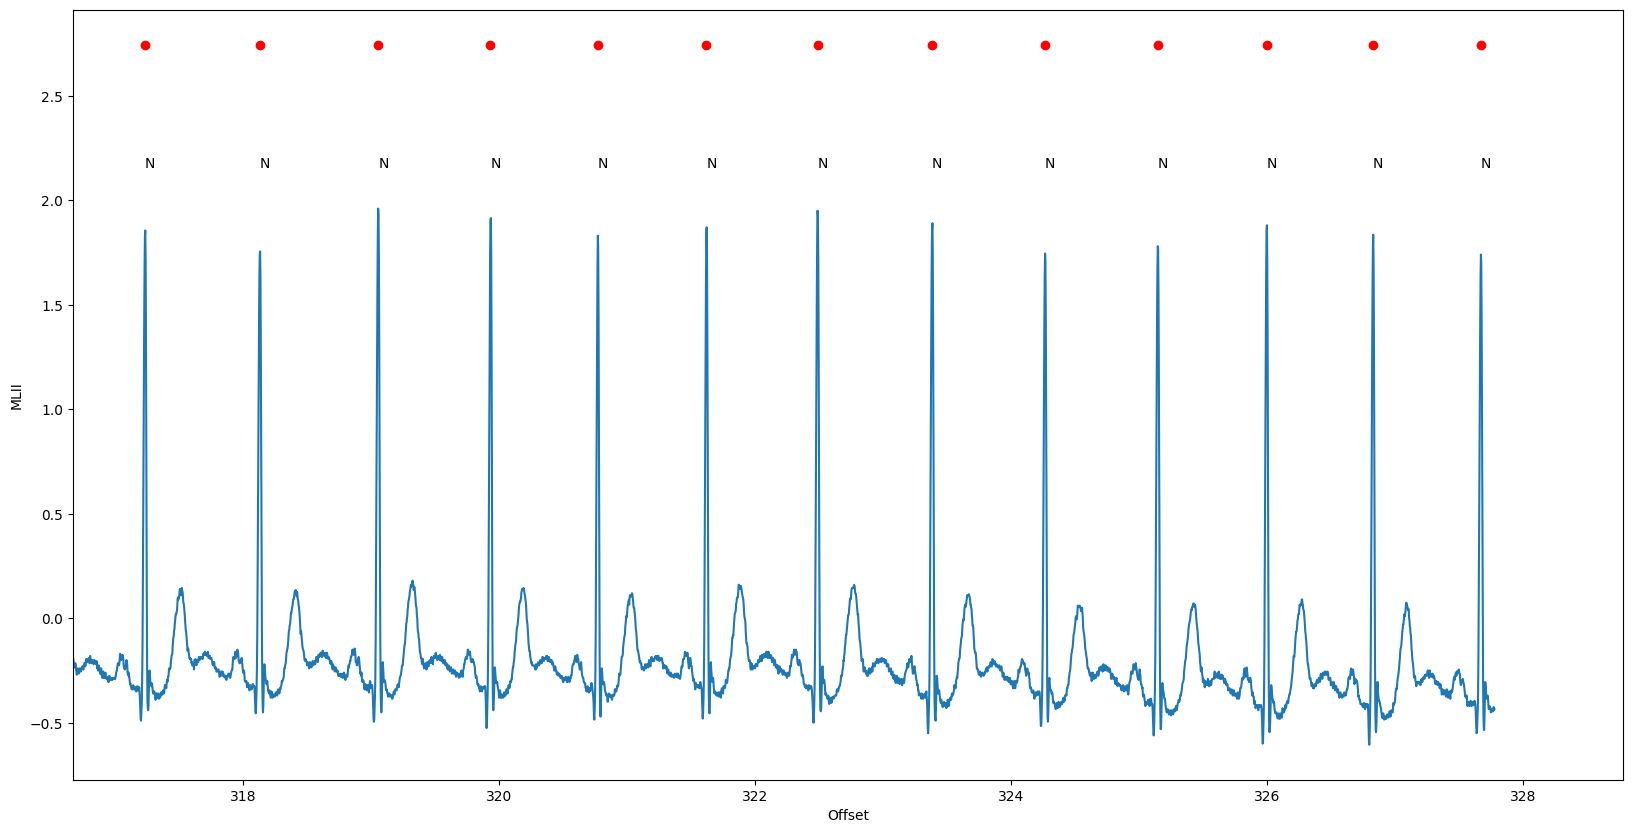

In [5]:
FILE=1                # There are 48 files.
CHANNEL=0             # There are 2 channels
SAMPLE_START=114000   # Start of the sample in the file.
SAMPLE_SIZE=4000      # Number of readings (360 per second).

record_name = '103'
record_path = os.path.join(os.getcwd(), record_name)
record = wfdb.rdsamp(record_path)
annotation = wfdb.rdann(record_path, 'atr')

# Get data and annotations for the samples selected below.
sample_end = SAMPLE_START + SAMPLE_SIZE
channel = record[0][SAMPLE_START:sample_end, CHANNEL]

# Plot the heart beats. Time scale is number of readings
# divided by sampling frequency.
times = (np.arange(SAMPLE_SIZE, dtype = 'float') + SAMPLE_START) / record[1].get('fs')
plt.figure(figsize=(20,10))
plt.plot(times, channel)

# Extract annotations.
where = np.logical_and(annotation.sample >= SAMPLE_START, annotation.sample < sample_end)
annots = annotation.sample[where] - SAMPLE_START
annotypes = np.array(annotation.symbol)
annotypes = annotypes[where]

# Plot the Annotations.
annotimes = times[annots]
plt.plot(annotimes, np.ones_like(annotimes) * channel.max() * 1.4, 'ro')

# Annotation codes.
for idx, annot in enumerate(annots):
    plt.annotate(annotypes[idx], xy = (times[annot], channel.max() * 1.1))

plt.xlim([SAMPLE_START / record[1].get('fs'), (sample_end / record[1].get('fs')) + 1])
plt.xlabel('Offset')
plt.ylabel(record[1].get('sig_name')[CHANNEL])
plt.show()

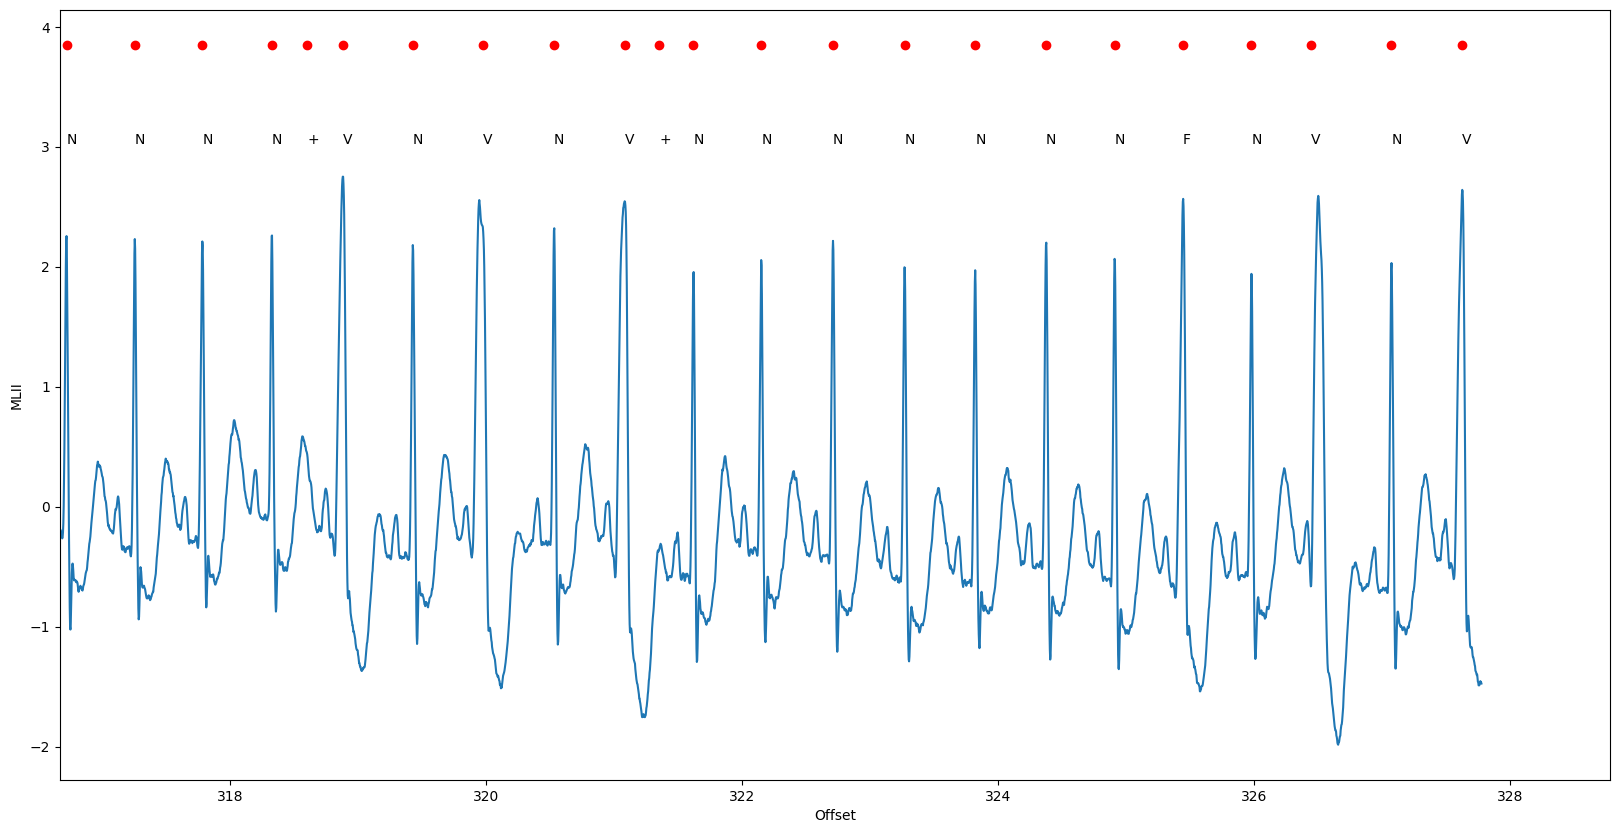

In [6]:
FILE=1                # There are 48 files.
CHANNEL=0             # There are 2 channels
SAMPLE_START=114000   # Start of the sample in the file.
SAMPLE_SIZE=4000      # Number of readings (360 per second).

record_name = '213'
record_path = os.path.join(os.getcwd(), record_name)
record = wfdb.rdsamp(record_path)
annotation = wfdb.rdann(record_path, 'atr')

# Get data and annotations for the samples selected below.
sample_end = SAMPLE_START + SAMPLE_SIZE
channel = record[0][SAMPLE_START:sample_end, CHANNEL]

# Plot the heart beats. Time scale is number of readings
# divided by sampling frequency.
times = (np.arange(SAMPLE_SIZE, dtype = 'float') + SAMPLE_START) / record[1].get('fs')
plt.figure(figsize=(20,10))
plt.plot(times, channel)

# Extract annotations.
where = np.logical_and(annotation.sample >= SAMPLE_START, annotation.sample < sample_end)
annots = annotation.sample[where] - SAMPLE_START
annotypes = np.array(annotation.symbol)
annotypes = annotypes[where]

# Plot the Annotations.
annotimes = times[annots]
plt.plot(annotimes, np.ones_like(annotimes) * channel.max() * 1.4, 'ro')

# Annotation codes.
for idx, annot in enumerate(annots):
    plt.annotate(annotypes[idx], xy = (times[annot], channel.max() * 1.1))

plt.xlim([SAMPLE_START / record[1].get('fs'), (sample_end / record[1].get('fs')) + 1])
plt.xlabel('Offset')
plt.ylabel(record[1].get('sig_name')[CHANNEL])
plt.show()

# ***Feature Extraction and Data Preprocessing***

In [7]:

# Specify the record directory and load all records
record_dir = os.getcwd()
records = []
realbeats = ['N','L','R','B','A','a','J','S','V','r',
             'F','e','j','n','E','/','f','Q','?']
answer=np.zeros((1,188))
for record_name in os.listdir(record_dir):
    if record_name.endswith('.dat'):
        record_path = os.path.join(record_dir, record_name[:-4])
        record = wfdb.rdrecord(record_path)
        pathpts = record_name.split('/')
        fn = pathpts[-1]

        # Get the sampling frequency and data shape
        fs = record.fs
        data_shape = record.p_signal.shape

        # Get the annotations
        ann_path = os.path.join(record_dir, record_name[:-4] + '.atr')
        ann = wfdb.rdann(record_path, 'atr')

        # Append the record and its information to the list
        record_info = {'record': record, 'fs': fs, 'data_shape': data_shape, 'ann': ann}
        records.append(record_info)

        # Get the ECG values from the file.
        data = record.p_signal.transpose()

        # Generate the classifications based on the annotations.
        # 0.0 = undetermined
        # 1.0 = normal
        cat = np.array(ann.symbol)
        rate = np.zeros_like(cat, dtype='float')
        for catid, catval in enumerate(cat):
            if (catval == 'N'):
                rate[catid] = 1.0 # Normal
            elif (catval == 'S'):
                rate[catid] = 2.0 #Supraventricular premature beat
            elif (catval == 'V'):
                rate[catid] = 3.0 # Premature ventricular contraction
            elif (catval == 'F'):
                rate[catid] = 4.0 #Fusion of ventricular and normal beat
            elif (catval in realbeats):
                rate[catid] = 5.0 # Unclassifiable beat
        rates = np.zeros_like(data[0], dtype='float')
        rates[ann.sample] = rate
        indices = np.arange(data[0].size, dtype='int')

        # Process each channel separately (2 per input file).
        for channelid, channel in enumerate(record.sig_name):
            print('    ECG channel type:', channel,channelid)
            
            # Get the ECG values for the current channel.
            ecg_values = record.p_signal[:, channelid]

            # Find rpeaks in the ECG data. Most should match with
            # the annotations.
            out = ecg.ecg(signal=ecg_values, sampling_rate=360, show=False)
            rpeaks = np.zeros_like(ecg_values, dtype='float')
            rpeaks[out['rpeaks']] = 1.0
            
            beatstoremove = np.array([0])

            # Split into individual heartbeats. For each heartbeat
            # record, append classification (normal/'S'/'V'/'F'/'Q').
            beats = np.split(ecg_values, out['rpeaks'])
            for idx, idxval in enumerate(out['rpeaks']):
                firstround = idx == 0
                lastround = idx == len(beats) - 1

                # Skip first and last beat.
                if (firstround or lastround):
                    continue

                # Get the classification value that is on
                # or near the position of the rpeak index.
                fromidx = 0 if idxval < 10 else idxval - 10
                toidx = idxval + 10
                catval = rates[fromidx:toidx].max()
                
                # Skip beat if there is no classification.
                if (catval == 0.0):
                    beatstoremove = np.append(beatstoremove, idx)
                    continue

                # Normal beat is now classified as 0.0 and other beats as 1.0, 2.0, 3.0, 4.0.
                catval = catval - 1.0

                # Append some extra readings from next beat.
                beats[idx] = np.append(beats[idx], beats[idx+1][:40])

                # Normalize the readings to a 0-1 range for ML purposes.
                beats[idx] = (beats[idx] - beats[idx].min()) / beats[idx].ptp()

                # Resample from 360Hz to 125Hz
                newsize = int((beats[idx].size * 125 / 360) + 0.5)
                beats[idx] = signal.resample(beats[idx], newsize)


                # Skipping records that are too long.
                if (beats[idx].size > 187):
                    beatstoremove = np.append(beatstoremove, idx)
                    continue

                # Pad with zeroes.
                zerocount = 187 - beats[idx].size
                beats[idx] = np.pad(beats[idx], (0, zerocount), 'constant', constant_values=(0.0, 0.0))

                # Append the classification to the beat data.
                beats[idx] = np.append(beats[idx], catval)

            beatstoremove = np.append(beatstoremove, len(beats)-1)

            # Remove first and last beats and the ones without classification.
            beats = np.delete(beats, beatstoremove)

            # Save to CSV file.
            savedata = np.array(list(beats[:]), dtype=np.float)
            answer=np.concatenate((answer,savedata), axis=0)
            # print(savedata.shape)


    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V2 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: V5 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V2 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V5 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: V5 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V2 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: V5 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: MLII 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V2 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V5 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V4 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1
    ECG channel type: MLII 0


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-7-93a04bfb9321>:118: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


    ECG channel type: V1 1


# ***Total number of Heart beats segmented***

In [8]:
answer.shape

(149359, 188)

In [9]:
df_original = pd.DataFrame(answer)
df_original=df_original.drop(0)
df_original

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
1,0.702689,0.813226,0.151830,0.068978,0.086587,0.141946,0.085944,0.109181,0.068552,0.086565,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.697762,0.676600,0.015163,0.071940,0.074205,0.102395,0.059207,0.074114,0.030159,0.057039,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.674047,0.770846,0.079087,0.035786,0.070586,0.097683,0.051781,0.071337,0.031134,0.055312,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.696580,0.852668,0.104336,0.048838,0.083775,0.109022,0.060975,0.078970,0.043573,0.066435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.693693,0.827298,0.119556,0.059384,0.087469,0.110351,0.066213,0.082092,0.049471,0.066369,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149354,0.794406,0.749113,0.230911,0.256252,0.167967,0.062560,-0.011613,0.071884,0.157248,0.257818,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
149355,0.774887,0.693777,0.182451,0.233159,0.116215,0.045532,0.012002,0.126181,0.210804,0.294106,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
149356,0.784643,0.778991,0.263598,0.279832,0.199364,0.098870,0.007030,0.067120,0.121128,0.223757,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
149357,0.268325,0.304688,0.121543,0.035512,0.048068,0.074584,0.290778,0.714673,0.914341,1.004930,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [11]:
df_original[187].value_counts()
# 1.0 Normal
# 2.0 Supraventricular premature beat
# 3.0 Premature ventricular contraction
# 4.0 Fusion of ventricular and normal beat
# 5.0 Unclassifiable beat

0.0    112447
4.0     31304
2.0      4783
3.0       820
1.0         4
Name: 187, dtype: int64

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [13]:


one_df=df_original[df_original[187]==1] #the class label 1 are only 4 instances . Hence, repetative addition of the same class label instances
one_df

df=pd.concat([df_original,one_df],axis=0,ignore_index=True)
df


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.702689,0.813226,0.151830,0.068978,0.086587,0.141946,0.085944,0.109181,0.068552,0.086565,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.697762,0.676600,0.015163,0.071940,0.074205,0.102395,0.059207,0.074114,0.030159,0.057039,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.674047,0.770846,0.079087,0.035786,0.070586,0.097683,0.051781,0.071337,0.031134,0.055312,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.696580,0.852668,0.104336,0.048838,0.083775,0.109022,0.060975,0.078970,0.043573,0.066435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.693693,0.827298,0.119556,0.059384,0.087469,0.110351,0.066213,0.082092,0.049471,0.066369,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149357,0.323226,0.353626,0.157593,0.066298,0.058167,0.130438,0.429522,0.785093,0.922032,0.997242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
149358,0.696857,0.671122,0.061700,0.078461,0.056841,0.068854,0.039561,0.062272,0.048856,0.062665,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
149359,0.719439,0.719067,0.156641,0.149131,0.095305,0.161552,0.108794,0.146510,0.105051,0.142070,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
149360,0.790847,0.667305,0.704660,0.732847,0.734461,0.714703,0.733889,0.745819,0.715121,0.707548,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# ***3-Fold Cross validation***

In [14]:
from sklearn.model_selection import StratifiedKFold
kf=StratifiedKFold(n_splits=3)
x=df.drop([187],axis='columns')
y=df[187]
x

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.702689,0.813226,0.151830,0.068978,0.086587,0.141946,0.085944,0.109181,0.068552,0.086565,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.697762,0.676600,0.015163,0.071940,0.074205,0.102395,0.059207,0.074114,0.030159,0.057039,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.674047,0.770846,0.079087,0.035786,0.070586,0.097683,0.051781,0.071337,0.031134,0.055312,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.696580,0.852668,0.104336,0.048838,0.083775,0.109022,0.060975,0.078970,0.043573,0.066435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.693693,0.827298,0.119556,0.059384,0.087469,0.110351,0.066213,0.082092,0.049471,0.066369,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149357,0.323226,0.353626,0.157593,0.066298,0.058167,0.130438,0.429522,0.785093,0.922032,0.997242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149358,0.696857,0.671122,0.061700,0.078461,0.056841,0.068854,0.039561,0.062272,0.048856,0.062665,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149359,0.719439,0.719067,0.156641,0.149131,0.095305,0.161552,0.108794,0.146510,0.105051,0.142070,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149360,0.790847,0.667305,0.704660,0.732847,0.734461,0.714703,0.733889,0.745819,0.715121,0.707548,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
for train_index,test_index in kf.split(x,y):
  x_train,x_test=x.iloc[train_index],x.iloc[test_index]
  y_train,y_test=y.iloc[train_index],y.iloc[test_index]
  model_rf=RandomForestClassifier()
  model_rf.fit(x_train,y_train)
  predict_rf=model_rf.predict(x_test)
  print(classification_report(y_test,predict_rf))





              precision    recall  f1-score   support

         0.0       0.82      0.97      0.89     37483
         1.0       1.00      1.00      1.00         3
         2.0       0.86      0.27      0.41      1595
         3.0       0.97      0.51      0.67       273
         4.0       0.75      0.33      0.46     10434

    accuracy                           0.81     49788
   macro avg       0.88      0.62      0.68     49788
weighted avg       0.81      0.81      0.78     49788

              precision    recall  f1-score   support

         0.0       0.81      0.94      0.87     37482
         1.0       1.00      1.00      1.00         2
         2.0       0.40      0.46      0.43      1594
         3.0       0.41      0.65      0.50       274
         4.0       0.64      0.22      0.33     10435

    accuracy                           0.77     49787
   macro avg       0.65      0.65      0.63     49787
weighted avg       0.76      0.77      0.74     49787

              precisio

# ***Train Test Split***

In [18]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.33)
model1=RandomForestClassifier()
model1.fit(x_train,y_train)
predict_1=model1.predict(x_test)
cm = confusion_matrix(y_test, predict_1)
# Display confusion matrix



In [17]:
print(classification_report(y_test,predict_1))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     37148
         1.0       0.00      0.00      0.00         2
         2.0       0.92      0.82      0.87      1525
         3.0       0.96      0.65      0.77       249
         4.0       0.99      0.93      0.96     10366

    accuracy                           0.97     49290
   macro avg       0.77      0.68      0.72     49290
weighted avg       0.97      0.97      0.97     49290



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
print(cm)

[[36935     0    37     0    85]
 [    0     2     0     0     0]
 [  233     0  1325     6    12]
 [   91     0    22   183     1]
 [  728     0    29     0  9601]]


# ***Confusion Matrix***

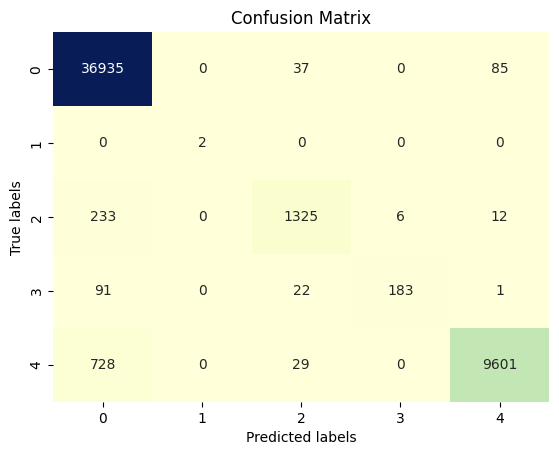

In [23]:
import seaborn as sns
sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt="d", cbar=False)

# Add labels and title to the plot
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()
